In [18]:
import multiprocess as mp

from glob import glob
import re
import pandas as pd
import numpy as np
import os

from PIL import Image
import cv2

import matplotlib.pyplot as plt

%matplotlib inline

# Cleaning of wine label data set

Read in sizes of all wine labels to begin analysis.

In [2]:
snooth_images = glob('../priv/images/snooth_dot_com_*.*')
wine_dot_com_images = glob('../priv/images/wine_dot_com_*.*')

int_sorter = lambda x: int(re.search(r"""_([0-9]+)\.""", x).group(1))
snooth_images = sorted(snooth_images, key=int_sorter)
wine_dot_com_images = sorted(wine_dot_com_images, key=int_sorter)

In [3]:
def get_sizes(file_list):
    
    file_df = list()

    for fil in file_list:
        try:
            with Image.open(fil) as im:
                width, height = im.size        
        except:
            width = np.NaN
            height = np.NaN

        file_ser = pd.Series({'image_name':fil, 'width':width, 'height':height})
        
        file_df.append(file_ser)
        
    return file_df

In [4]:
file_list = snooth_images
file_list.extend(wine_dot_com_images)

In [5]:
nthreads = 48
pool = mp.Pool(processes=nthreads)
size_list = pool.map(get_sizes, np.array_split(file_list, nthreads))
pool.close()

/home/ubuntu/miniconda/envs/scienv2_oldcv/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/miniconda/envs/scienv2_oldcv/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [6]:
image_size_df = pd.concat(sum(size_list,[]), axis=1).T

In [7]:
image_size_df['height'] = image_size_df.height.astype(int)
image_size_df['width'] = image_size_df.width.astype(int)
image_size_df['area'] = image_size_df.height * image_size_df.width

In [8]:
image_size_df.shape

(57927, 4)

In [9]:
def extract_basename(x):
    return os.path.splitext(os.path.basename(x))[0]

image_size_df['basename'] = image_size_df.image_name.apply(extract_basename)

In [10]:
image_size_df.area.min(), image_size_df.area.max()

(1, 2929184)

# Visualize label sizes
Visualize the size of the images in a histogram.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d84ba790>]], dtype=object)

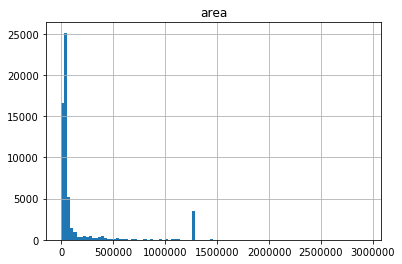

In [13]:
image_size_df.hist('area', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d8446b50>]], dtype=object)

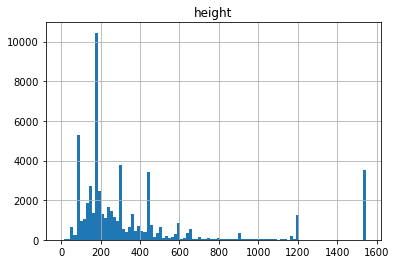

In [14]:
image_size_df.hist('height', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89d7f96bd0>]], dtype=object)

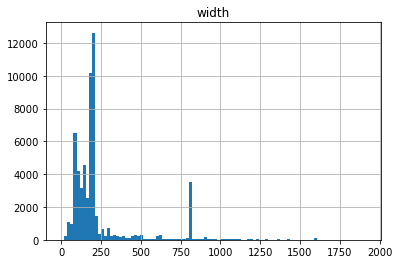

In [15]:
image_size_df.hist('width', bins=100)

# Data cleaning notes

Specifically, there are many labels such at the one below that are "placeholders". There are other labels that are additionally just very small.

In [16]:
img = Image.open('../priv/images/snooth_dot_com_47220.png')
img.size

(87, 87)

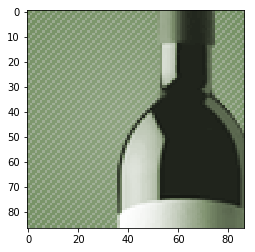

In [19]:
plt.imshow(img)

It also appears that some of the very large images will need to be removed. I believe these are only in the Wine.com data set.

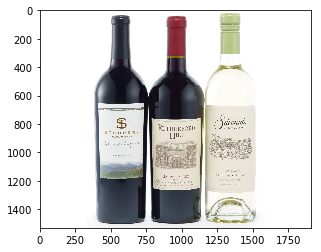

In [21]:
plt.imshow(Image.open('../priv/images/wine_dot_com_8516.jpg'))

# Data for preliminary analysis
Save the filenames of the high(-ish) resolution images to use for preliminary analysis. 

In [22]:
mask = (image_size_df.area>1.0e6)&(image_size_df.area<1.5e6)
mask.sum()

4117

In [23]:
image_size_df.loc[mask].to_pickle('../priv/pkl/20_wine_label_analysis_large_labels.pkl')

In [32]:
image_size_df.head()

,height,image_name,width,area,basename
0,169,../priv/images/snooth_dot_com_0.jpeg,200,33800,snooth_dot_com_0
1,320,../priv/images/snooth_dot_com_1.jpeg,100,32000,snooth_dot_com_1
2,300,../priv/images/snooth_dot_com_2.png,80,24000,snooth_dot_com_2
3,100,../priv/images/snooth_dot_com_3.jpeg,35,3500,snooth_dot_com_3
4,377,../priv/images/snooth_dot_com_4.jpeg,100,37700,snooth_dot_com_4


# Cleaning of data
Remove small images

In [24]:
mask = image_size_df.area>10000
image_size_df_out = image_size_df[mask]
image_size_df_out.shape

(51372, 5)

In [25]:
mask = np.invert((image_size_df.area>1.5e6)&(image_size_df['basename'].str.contains('wine_dot_com')))
image_size_df_out = image_size_df_out[mask]
image_size_df_out.shape

/home/ubuntu/miniconda/envs/scienv2_oldcv/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(51364, 5)

In [26]:
image_size_df_out.to_pickle('../priv/pkl/20_wine_label_analysis_all_labels.pkl')

## Average color histogram
Histogram of nine image regions

In [29]:
image = np.asarray(Image.open('../priv/images/wine_dot_com_8516.jpg'))
height, width = image.shape[:2]
nrows = 3
ncols = 3
w = int(width/ncols)
h = int(height/nrows)

segments = list()
for r in range(nrows):
    for c in range(ncols):
        x_beg = c*w
        y_beg = r*h
        
        if c != (ncols-1):
            x_end = (c+1)*w
        else:
            x_end = width+1
            
        if r != (nrows-1):
            y_end = (r+1)*h
        else:
            y_end = height+1
            
        segments.append((x_beg, x_end, y_beg, y_end))
        
segments

[(0, 637, 0, 510),
 (637, 1274, 0, 510),
 (1274, 1913, 0, 510),
 (0, 637, 510, 1020),
 (637, 1274, 510, 1020),
 (1274, 1913, 510, 1020),
 (0, 637, 1020, 1533),
 (637, 1274, 1020, 1533),
 (1274, 1913, 1020, 1533)]

In [30]:
bins = (4, 6, 3)
# bins = (64, 64, 64)

image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
features = []

# loop over the segments
for (x_beg, x_end, y_beg, y_end) in segments:
    
    # construct a mask for each part of the image
    squareMask = np.zeros(image.shape[:2], dtype='uint8')
    cv2.rectangle(squareMask, (x_beg, y_beg), (x_end, y_end), 255, -1)
    
    hist = cv2.calcHist([image], [0, 1, 2], squareMask, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist).flatten()
    
    features.extend(hist)

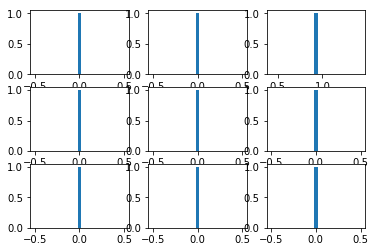

In [31]:
f, axList = plt.subplots(nrows=3, ncols=3)

for his,ax in zip(hist, axList.flatten()):
    ax.hist(his, bins=25)